## Goal:

Use [transfer learning](https://arxiv.org/abs/1805.08974) to train an image classifier to differentiate images of my partner, Sid, from images from the [Flickr Faces HQ Dataset](https://github.com/NVlabs/ffhq-dataset).

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from PIL import Image

In [2]:
path = '/storage/data/sidbot/train/'

In [3]:
fns = get_image_files(path)
fns

(#3745) [Path('/storage/data/sidbot/train/sid/00006(3).jpg'),Path('/storage/data/sidbot/train/sid/Screenshot 2020-11-07 at 23.18.20.png'),Path('/storage/data/sidbot/train/sid/Screenshot 2020-11-07 at 23.17.51.png'),Path('/storage/data/sidbot/train/sid/IMG_2191.jpg'),Path('/storage/data/sidbot/train/sid/IMG_2186.jpg'),Path('/storage/data/sidbot/train/sid/IMG_2225.jpg'),Path('/storage/data/sidbot/train/sid/IMG_2258.jpg'),Path('/storage/data/sidbot/train/sid/00006(6).jpg'),Path('/storage/data/sidbot/train/sid/index(19).jpg'),Path('/storage/data/sidbot/train/sid/IMG_2223.jpg')...]

I used the data block API to pass information about how to get our image files, how to label them, how to split them and how to transform them:

In [4]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(460, min_scale=0.5),
    batch_tfms=aug_transforms(size=224))

In [5]:
train_dls = images.dataloaders(path)

In [6]:
train_dls.vocab

['sid', 'someone_else']

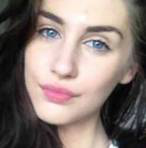

In [7]:
example_pic = path + 'sid/index.jpg'
img_sid = Image.open(example_pic)
img_sid

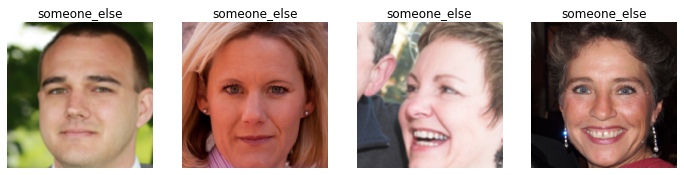

In [8]:
train_dls.valid.show_batch(max_n=4, nrows=1)

I will now train a baseline model using a ResNet with 18 hidden layers:

In [9]:
baseline_learner = cnn_learner(train_dls, models.resnet18, metrics=accuracy, pretrained=False,)

In [10]:
baseline_learner.fit(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.742514,0.354412,0.909212,00:21
1,0.486893,0.185731,0.954606,00:20
2,0.345835,0.157521,0.967957,00:20
3,0.258204,0.124332,0.962617,00:21


I will try and improve on my baseline's accuracy with a model called ResNet34, pretrained on [ImageNet](http://www.image-net.org/):

In [11]:
learn = cnn_learner(train_dls, models.resnet34, metrics=accuracy)
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 64 x 64 x 56 x 56    0          False     
_________________________________________________

I will then adapt the pretrained model for our specific problem:

In [12]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.962462,0.462697,0.798398,00:21


epoch,train_loss,valid_loss,accuracy,time
0,0.463161,0.247061,0.919893,00:22
1,0.322637,0.118016,0.969292,00:22
2,0.194460,0.040039,0.994660,00:22
3,0.122932,0.035960,0.995995,00:22


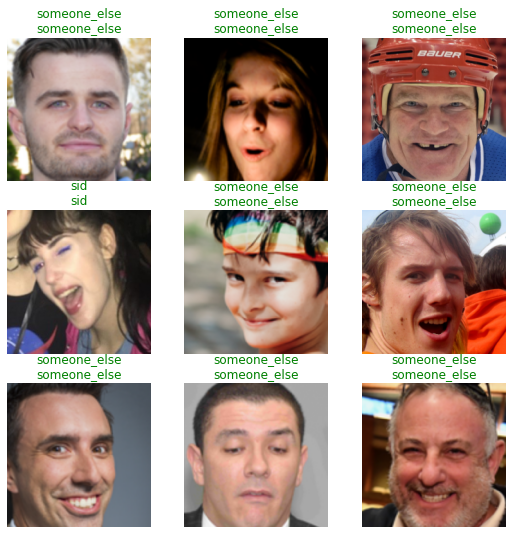

In [13]:
learn.show_results()

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

The model is performing very well but has produced 3 false positives:

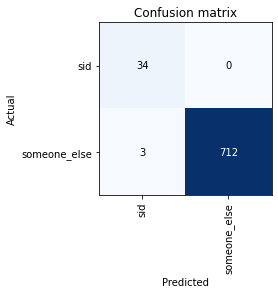

In [15]:
interp.plot_confusion_matrix()

A look at the plot_top_losses function is encouraging since the mistake it has made it understandable:

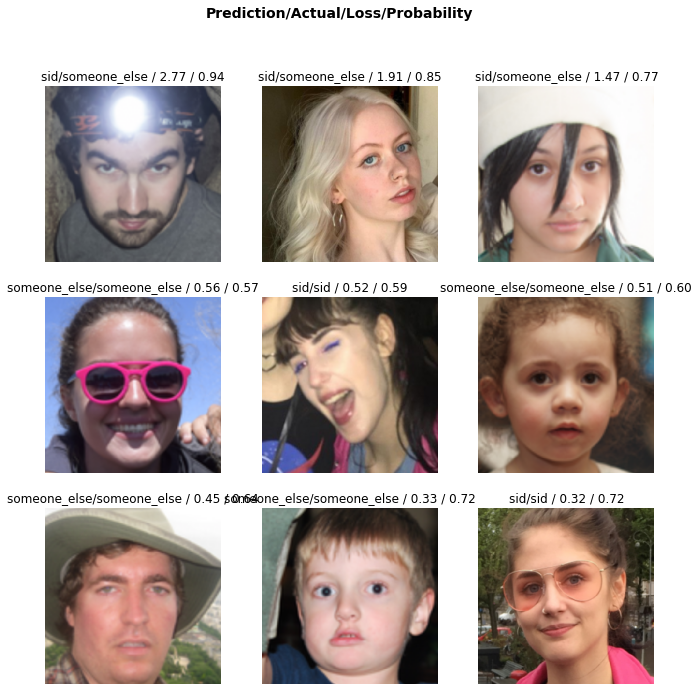

In [16]:
interp.plot_top_losses(9, figsize=(11,11))

A look at the classification report shows that the accuracy of the model is very good however there is worse precision for classfying images with the 'sid' label:

In [17]:
interp.print_classification_report()

              precision    recall  f1-score   support

         sid       0.92      1.00      0.96        34
someone_else       1.00      1.00      1.00       715

    accuracy                           1.00       749
   macro avg       0.96      1.00      0.98       749
weighted avg       1.00      1.00      1.00       749

